# Optimizing Data Distributions in Batch Reinforcement Learning

In [1]:
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from scipy.stats import entropy

from tqdm import tqdm

sns.set_style("darkgrid")
matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont}')
matplotlib.rcParams.update({'font.size': 16})

## Grid environment

In [2]:
ACTIONS_DICT = {0: 'u', 1: 'd', 2: 'l', 3: 'r', 4: 's'}

In [3]:
class GridEnv:
    
    # Adapted from https://github.com/KaleabTessera/Gridworld-Markov-Decision-Process/blob/master/MDPs.ipynb

    def __init__(self, height, width, starting_state_dist, rewards, time_limit, stochasticity=0.0):
        
        self.width = width
        self.height = height
        
        self.stochasticity = stochasticity

        # Reward function.
        self.R = np.zeros((height,width))

        # Obstacles.
        #self.R[2,:-1] = np.nan

        # Goal state.
        self.rewards = rewards
        for r in self.rewards:
            self.R[r] = 1
        
        # States.
        self.S = [] # state to idx.
        idxs = []
        for index, reward in np.ndenumerate(self.R):
            # Not an obstacle
            if(not np.isnan(reward)):
                self.S.append(index)
                idxs.append(index)
        self.S = np.asarray(self.S)
        self.idx_to_state = {str(k): v for (k,v) in zip(idxs,range(len(idxs)))}

        # Action space.
        self.A = list(ACTIONS_DICT.values())
        
        # Initial state.
        self.starting_state_dist = starting_state_dist

        self.time_limit = time_limit
        self.step_counter = 0
    
    def get_state_space_size(self):
        return len(self.S)    

    def get_action_space_size(self):
        return len(self.A)
    
    def render(self):
            
        grid_world = np.empty((self.width, self.height))
        grid_world[:] = np.nan
        for r in self.rewards:
            grid_world[r] = 1

        grid_world[self.s[0],self.s[1]] = 2

        fig, ax = plt.subplots(figsize=(6,6))

        plt.pcolor(grid_world[::-1], edgecolors='w', linewidths=2)
        loc = matplotlib.ticker.MultipleLocator(base=1.0)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)            

        plt.grid(color='black')
        
        plt.show()
        
        
    def plot_mu(self, mu, vmin, vmax):

        fig, ax = plt.subplots(figsize=(4,4))
        
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        mesh = plt.pcolormesh(mu, norm=norm)
        
        fig.colorbar(mesh,norm=norm)

        plt.grid(color='black')
        plt.show()
        
    def reset(self):
        starting_state = np.random.choice(np.arange(len(self.S)), p=self.starting_state_dist)
        self.s = list(self.S[starting_state])
        self.step_counter = 0
        return self.idx_to_state[str(tuple(self.s))]
            
    def step(self, action):
        new_s, new_r = self.take_step(self.s, action)
        
        if np.random.rand() <= self.stochasticity:
            new_s = np.random.choice(np.arange(len(self.S)))
            new_s = list(self.S[new_s])

        self.s = new_s
            
        self.step_counter += 1
        is_done = False
        if self.step_counter >= self.time_limit:
            is_done = True
            
        return new_r, self.idx_to_state[str(tuple(new_s))], is_done
        
    def check_if_s_in_S(self,s):
        for possible_s in self.S:
            if(possible_s[0] == s[0] and possible_s[1] == s[1]):
                return True
        return False
    
    def is_out_of_bounds(self,new_s):
        if((new_s[0] < 0 or new_s[0]>self.height-1) or (new_s[1] < 0 or new_s[1]>self.width-1)):
            return True
        return False
    
    def take_step(self, s, a):
        if(a not in self.A):
            raise ValueError('Unknown action', a)
        new_s = s.copy()
        if(a == 'u'):
            new_s[0] -= 1
        elif(a == 'd'):
            new_s[0] += 1
        elif(a == 'l'):
            new_s[1] -= 1
        elif(a == 'r'):
            new_s[1] += 1
        elif(a == 's'):
            new_s[1] = new_s[1]

        # Out of bounds - stay in same place
        if(self.is_out_of_bounds(new_s)):
            return s, 0.0
        # Check Obstacles - not in possible states - stay in same place
        elif(not self.check_if_s_in_S(new_s)):
            return s, 0.0
        return new_s, self.R[new_s[0],new_s[1]]
    
    def is_obstacle(self,s):
        if(np.isnan(self.R[s[0],s[1]])):
            return True
        
    def get_R(self):
        rewards_list = []
        for index, reward in np.ndenumerate(self.R):
            # Not an obstacle
            if(not np.isnan(reward)):
                rewards_list.append(reward)
        return np.array(rewards_list)
    
    def get_P(self):
        nS = self.get_state_space_size()
        nA = self.get_action_space_size()
        P = np.zeros((nA,nS,nS))
        for act_idx, act in enumerate(self.A):
            for state_idx, state in enumerate(self.S):
                new_state, _ = self.take_step(state,act)
                new_state_idx = self.idx_to_state[str(tuple(new_state))]
                P[act_idx,state_idx,new_state_idx] = 1.0
                
        for act_idx, act in enumerate(self.A):
            for state_idx, state in enumerate(self.S):
                P[act_idx,state_idx] = P[act_idx,state_idx]*(1-self.stochasticity)
                P[act_idx,state_idx] = P[act_idx,state_idx] + (self.stochasticity / len(P[act_idx,state_idx]))
        
        return P

In [4]:
def run_episode(env, policy, render=False):
    states = []
    actions = []
    cumulative_reward = 0.0
    t = 0

    state = env.reset()
    states.append(state)
    
    if render:
        print("t=", t)
        print("state", state)
        env.render()

    is_done = False
    while not is_done:
        
        action = np.random.choice(np.arange(len(policy[state,:])), p=policy[state,:])
        action = ACTIONS_DICT[action]
        
        reward, state, is_done = env.step(action)
        
        cumulative_reward += reward
        
        actions.append(action)
        states.append(state)

        t += 1

        if render:
            print("action", action)
            print("t=", t)
            print("state", state)
            env.render()
        
    return states, actions, cumulative_reward

#### four_state_mdp (Example MDP)

In [5]:
four_state_env = GridEnv(width=4,height=1,starting_state_dist=np.array([0.0, 1.0, 0.0, 0.0]),
                   rewards=[(0,0)],time_limit=2)
four_state_mdp = {"state_space_size": four_state_env.get_state_space_size(),
            "action_space_size": four_state_env.get_action_space_size(),
            "P": four_state_env.get_P(),
            "R": four_state_env.get_R(),
            "gamma": 0.5}

#### grid_mdp

In [6]:
init_state_dist = np.zeros((8,8))
init_state_dist[0,0] = 1.0
grid_env = GridEnv(width=8,height=8,starting_state_dist=init_state_dist.flatten(),
                   rewards=[(7,7)],time_limit=20)
grid_mdp = {"state_space_size": grid_env.get_state_space_size(),
            "action_space_size": grid_env.get_action_space_size(),
            "P": grid_env.get_P(),
            "R": grid_env.get_R(),
            "gamma": 0.5}

## Multi-path environment

In [7]:
def multi_path_mdp_get_transitions_aux(s, a):
    correct_actions = np.random.randint(low=0, high=5, size=5*5+2, dtype=np.int32)
    init_action_random_p = 0.01 # first action randomness.

    if s == 0: # Start state.
        probs = [init_action_random_p]*5
        probs[a] += 1 - init_action_random_p*5
        return [1,6,11,16,21], probs

    elif s == 26: # Terminal (dead) state.
        return [s], [1.0]

    elif s in [5,10,15,20,25]: # Terminal (win) state.
        return [s], [1.0]

    else:
        good_action_idx = correct_actions[s]
        if a == good_action_idx:
            return [s+1], [1.0] # Move one step forward.
        else:
            return [26], [1.0] # Move to dead state.
        
def multi_path_mdp_get_transitions(s, a):
    next_states, probs = multi_path_mdp_get_transitions_aux(s, a)
    return {next_state: prob for next_state, prob in zip(next_states, probs)}

def multi_path_mdp_get_P():
    P_matrix = []
    for a in range(5):
        a_list = []
        for s in range(5*5+2):
            transitions = multi_path_mdp_get_transitions(s,a)
            p_line = np.zeros(5*5+2)
            for s, prob in transitions.items():
                p_line[s] = prob
            a_list.append(p_line)
        P_matrix.append(a_list)
    return np.array(P_matrix)

#print(multi_path_mdp_get_P())

multi_path_mdp = {"state_space_size": 5*5+2,
            "action_space_size": 5,
            "P": multi_path_mdp_get_P(),
            "R": None, # (irrelevant from the PoV of concentrability).
            "gamma": 0.5}

# Concentrability coefficients

#### eval_mu

In [8]:
def log_sum_exp(x):
    return np.log(np.sum(np.exp(x)))

In [9]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [10]:
def eval_mu(mdp, mu, rho, M, use_soft_max):

    # Evaluates concentrability coefficient using backward induction.
    
    nS = mdp["state_space_size"]
    nA = mdp["action_space_size"]
    P = mdp["P"]
    gamma = mdp["gamma"]

    opt_policy = np.zeros((M, nS, nA))
    U = np.zeros((M+1, nS))

    U[-1,:] = np.sqrt((1.0/mu)) # (M, nS) Last step reward.

    for t in range(M-1, -1, -1): # M-1, ..., 0 (included).
        
        Q_t = np.zeros((nA, nS))
        for action in range(nA):
            Q_t[action,:] = np.dot(P[action], U[t+1,:])
        U[t,:] = np.max(Q_t, axis=0)

        policy_t = np.zeros((nS, nA))
        policy_act_idxs = np.argmax(Q_t, axis=0)
        policy_t[np.arange(nS), policy_act_idxs] = 1.0
        opt_policy[t,:,:] = policy_t

    sum_val = 0.0
    for m in range(1,M+1):
        sum_val += m*gamma**(m-1)*np.dot(rho, U[M-m])
        
    if use_soft_max:
        max_val = log_sum_exp(1.0/(mu**0.5))
    else:
        # hard max.
        max_val = np.max(1.0/(mu**0.5))
        
    c_val = (1-gamma)**2 * sum_val + gamma**M * (M-gamma*M+1)*max_val 

    return c_val, U, opt_policy

In [11]:
# Test eval_mu() for four_state_mdp.
mu_dist = np.array([0.01, 0.4945, 0.4945, 0.001])
rho = np.array([0.0, 1.0, 0.0, 0.0])
c_val, U, opt_policies = eval_mu(four_state_mdp, mu_dist, rho=rho, M=20, use_soft_max=True)
print("c_val", c_val)
print(opt_policies)
#print(U)
# actions: {0: 'u', 1: 'd', 2: 'l', 3: 'r', 4: 's'}

c_val 26.21708245126285
[[[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  

#### get_mu_grad

In [12]:
def get_mu_grad(mdp, opt_policies, mu, rho, M, use_soft_max):
    
    # Computes gradient w.r.t. `mu` variable.
    
    #print('*'*10)
    #print('get_mu_grad()')
    #print(mu)

    gamma = mdp["gamma"]
    nS = mdp["state_space_size"]
    nA = mdp["action_space_size"]
    P = mdp["P"]
    
    #print('mdp:', mdp)
    #print("opt_policies", opt_policies)
    #print('M', M)
    #print('*'*20)

    def build_P_pi_m(policy):
        #print("build_P_pi_m()")
        P_pi_m = np.zeros((nS,nS))
        for a in range(nA):
            P_pi_m += np.dot(np.diag(policy[:,a]), P[a])
        #print("P_pi_m", P_pi_m)
        return P_pi_m

    # Build P_pi_1.
    P_pi_1 = build_P_pi_m(policy=opt_policies[-1])

    # Variable `beta` holds the expected state
    # distribution at a given timestep.
    beta = np.dot(rho, P_pi_1)

    mu_grad = np.zeros(nS)
    #print("mu_grad", mu_grad)

    #mu_grad += (-1) * (beta / (2 * mu**(1.5))) # (old version that uses an upper bound)
    norm = np.sqrt(np.dot(beta**2, 1.0 / mu))
    mu_grad += (-1) * (beta**2 / (2 * mu**2 * norm))
    #print("mu_grad", mu_grad)
    
    for m in range(2, M+1):
        #print('m', m)
        
        # Build P_pi_m.
        P_pi_m = build_P_pi_m(policy=opt_policies[-m])
        beta = np.dot(beta, P_pi_m)

        # mu_grad += (m * gamma**(m-1)) * (-1) * (beta / (2 * mu**(1.5))) # (old version that uses an upper bound)
        norm = np.sqrt(np.dot(beta**2, 1.0 / mu))
        mu_grad += (m * gamma**(m-1)) * (-1) * (beta**2 / (2 * mu**2 * norm))
        #print("mu_grad", mu_grad)

    if use_soft_max:
        max_grad = softmax(1.0/(mu**0.5)) * (-1.0/(2*mu**1.5))
    else:
        max_idx = np.argmax(1.0/mu)
        mask = np.zeros(nS)
        mask[max_idx] = 1.0
        max_grad = mask *((-1.0)/(2*mu**1.5))

    #print(max_idx)
    #print(mask)
    mu_grad = (1-gamma)**2 * mu_grad + gamma**M * (M-gamma*M + 1) * max_grad
    #print("mu_grad", mu_grad)
    
    return mu_grad

#### Full algorithm

In [13]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [14]:
class Adam:
    
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))
        self.__dict__.update(kwargs)
        self.iterations = 0
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.decay = decay
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_update(self, params, grads):
        """ params and grads are list of numpy arrays
        """
        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        
        """ #TODO: implement clipping
        if hasattr(self, 'clipnorm') and self.clipnorm > 0:
            norm = np.sqrt(sum([np.sum(np.square(g)) for g in grads]))
            grads = [clip_norm(g, self.clipnorm, norm) for g in grads]
        if hasattr(self, 'clipvalue') and self.clipvalue > 0:
            grads = [K.clip(g, -self.clipvalue, self.clipvalue) for g in grads]
        """
        
        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (np.sqrt(1. - np.power(self.beta_2, t)) /
                     (1. - np.power(self.beta_1, t)))

        if not hasattr(self, 'ms'):
            self.ms = [np.zeros(p.shape) for p in params]
            self.vs = [np.zeros(p.shape) for p in params]
    
        ret = [None] * len(params)
        for i, p, g, m, v in zip(range(len(params)), params, grads, self.ms, self.vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * np.square(g)
            p_t = p - lr_t * m_t / (np.sqrt(v_t) + self.epsilon)
            self.ms[i] = m_t
            self.vs[i] = v_t
            ret[i] = p_t
        
        self.iterations += 1

        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])
        
        return ret

In [15]:
def optimize_mu(mdp, mu_init, rho, M, K=10_000,
                alpha=1e-04, alpha_decay=0.0, 
                optimizer='sgd', use_soft_max=False):
    
    # Arguments:
    # - mu_init: initial mu distribution.
    # - rho: norm distribution.
    # - M: horizon.
    # - K: number of iterations.
    # - alpha: learning rate.
    # - alpha_decay: learning rate decay parameter.
    # - optimizer: 'sgd' or 'adam'.
    # - use_soft_max: whether to use soft max instead
    #       of the hard max (second term in the objective).
    
    print('Optimizing for optimal mu...')
    print("Arguments:")
    print('mu_init:', mu_init)
    print('rho:', rho)
    print('K:', K)
    print('M:', M)
    print('alpha:', alpha)

    c_val, _, _ = eval_mu(mdp, mu_init, rho=rho, M=M, use_soft_max=use_soft_max)
    print('Initial C value:', c_val)
    
    if optimizer not in ['sgd', 'adam']:
        raise ValueError('Unknown optimizer.')
    
    if optimizer == 'adam':
        adam_opt = Adam(lr=alpha, decay=alpha_decay)
    
    mu = mu_init

    c_vals = [c_val]
    mus = [mu]
    
    mu_grad_means = []
    mu_grad_stds = []

    for k in tqdm(range(K)):
        
        if k % 5_000 == 0:
            print(f'Iteration {k}: C-value={c_val}')

        c_val, _, opt_policies = eval_mu(mdp, mu, rho=rho, M=M, use_soft_max=use_soft_max)

        mu_grad = get_mu_grad(mdp, opt_policies=opt_policies, mu=mu, rho=rho, M=M, use_soft_max=use_soft_max)
        
        mu_grad_means.append(np.mean(mu_grad))
        mu_grad_stds.append(np.std(mu_grad))

        if optimizer == 'sgd':
            mu = mu - alpha * mu_grad
        elif optimizer == 'adam':
            mu = adam_opt.get_update([mu], [mu_grad])[0]
        
        mu = projection_simplex_sort(mu, z=1)

        # Ensure mu > 0 in order to prevent numerical instabilities.
        mu += 1e-07
        mu /= np.sum(mu)

        c_vals.append(c_val)
        mus.append(mu)

    c_val, _, _ = eval_mu(mdp, mu, rho=rho, M=M, use_soft_max=use_soft_max)
    print('Final C value:', c_val)
    
    return mus, c_vals, mu_grad_means, mu_grad_stds

In [16]:
def calculate_c_vals_from_sampled_mus(mdp, rho, M, use_soft_max, dirichlet_alpha=1.0, num_samples=1_000):
    
    # Samples mus from dirichlet distribution (with given alpha vector parameter)
    # and evaluates the C value for the sampled mus.
    
    # Sample mus from dirichlet prior.
    dirichlet_alphas = np.ones(mdp["state_space_size"]) * dirichlet_alpha
    sampled_mus = np.random.dirichlet(dirichlet_alphas, size=num_samples)

    sampled_mus_c_vals = []
    sampled_mus_entropies = []

    for s in range(num_samples):
        
        # Ensure coverability of the sampled mu.
        sampled_mu = sampled_mus[s,:]
        sampled_mu += 1e-07
        sampled_mu /= np.sum(sampled_mu)
        
        c_val, _, _ = eval_mu(mdp, sampled_mu, rho=rho, M=M, use_soft_max=use_soft_max)
        sampled_mus_c_vals.append(c_val)
        sampled_mus_entropies.append(entropy(sampled_mu))
        
    return sampled_mus_c_vals, sampled_mus_entropies

## Example MDP experiments

Hyperparameters:

four_state_mdp, gamma=0.2, rho=[0.0, 1.0, 0.0, 0.0]:
```
four_state_mdp_mu_init = np.array([0.85,0.05,0.05,0.05])
four_state_mdp_M = 5
four_state_mdp_K = 20_000
four_state_mdp_alpha = 1e-04
four_state_mdp_alpha_decay = 0.0
four_state_mdp_optimizer = 'adam'
four_state_mdp_use_soft_max = False
```

In [17]:
GAMMA = 0.2
four_state_env = GridEnv(width=4,height=1,starting_state_dist=np.array([0.0, 1.0, 0.0, 0.0]),
                   rewards=[(0,0)],time_limit=2)
four_state_mdp = {"state_space_size": four_state_env.get_state_space_size(),
            "action_space_size": four_state_env.get_action_space_size(),
            "P": four_state_env.get_P(),
            "R": four_state_env.get_R(),
            "gamma": GAMMA}

four_state_mdp_rho = np.array([0.0, 1.0, 0.0, 0.0])
four_state_mdp_mu_init = np.array([0.85,0.05,0.05,0.05])
four_state_mdp_M = 5
four_state_mdp_K = 20_000
four_state_mdp_alpha = 1e-04
four_state_mdp_alpha_decay = 0.0
four_state_mdp_optimizer = 'adam'
four_state_mdp_use_soft_max = False

mus, c_vals, mu_grad_means, mu_grad_stds = \
                optimize_mu(four_state_mdp,
                        mu_init=four_state_mdp_mu_init,
                        rho=four_state_mdp_rho,
                        M=four_state_mdp_M,
                        K=four_state_mdp_K,
                        alpha=four_state_mdp_alpha,
                        alpha_decay=four_state_mdp_alpha_decay,
                        optimizer=four_state_mdp_optimizer,
                        use_soft_max=four_state_mdp_use_soft_max)

Optimizing for optimal mu...
Arguments:
mu_init: [0.85 0.05 0.05 0.05]
rho: [0. 1. 0. 0.]
K: 20000
M: 5
alpha: 0.0001
Initial C value: 4.4721359549995805


  2%|██▌                                                                                                                                                                     | 306/20000 [00:00<00:06, 3054.63it/s]

Iteration 0: C-value=4.4721359549995805


 27%|█████████████████████████████████████████████▋                                                                                                                         | 5478/20000 [00:01<00:04, 3248.84it/s]

Iteration 5000: C-value=2.802116912640015


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10581/20000 [00:03<00:03, 3104.33it/s]

Iteration 10000: C-value=2.1982714149607165


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15484/20000 [00:04<00:01, 3229.07it/s]

Iteration 15000: C-value=2.000041987370111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3191.87it/s]

Final C value: 2.000129253179288


Lowest C value 2.0000026165303675
Lowest C value idx. 18445
Optimal mu [0.2500194  0.24999288 0.24998272 0.250005  ]
Optimal mu entropy 1.3862943596191335


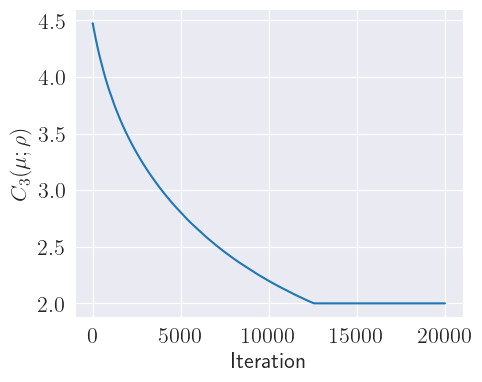

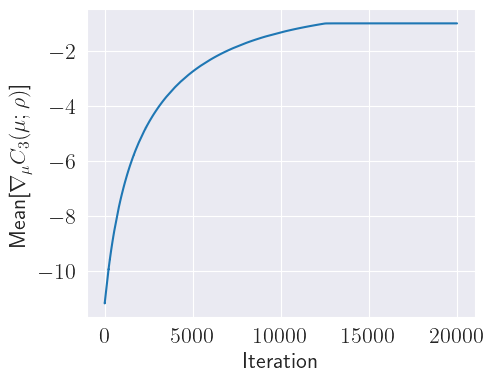

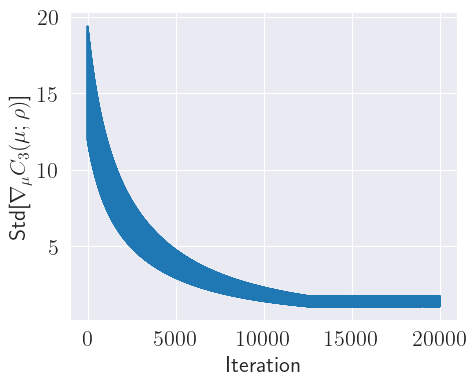

In [18]:
lowest_c_val = np.min(c_vals)
lowest_c_val_idx = np.argmin(c_vals)
print("Lowest C value", lowest_c_val)
print("Lowest C value idx.", lowest_c_val_idx)
print("Optimal mu", mus[lowest_c_val_idx])
print("Optimal mu entropy", entropy(mus[lowest_c_val_idx]))

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()
plt.plot(c_vals)
plt.xlabel('Iteration')
plt.ylabel(r'$C_3(\mu;\rho)$')
plt.show()
#plt.savefig('exampleMDP_obj_func.pdf', bbox_inches='tight', pad_inches=0)

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()
plt.plot(mu_grad_means)
plt.xlabel('Iteration')
plt.ylabel(r'Mean[$\nabla_\mu C_3(\mu;\rho)$]')
plt.show()

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()
plt.plot(mu_grad_stds)
plt.xlabel('Iteration')
plt.ylabel(r'Std[$\nabla_\mu C_3(\mu;\rho)$]')
plt.show()

Uniform mu C value 2.0000000000000004
Uniform mu entropy 1.3862943611198906
20001
20001


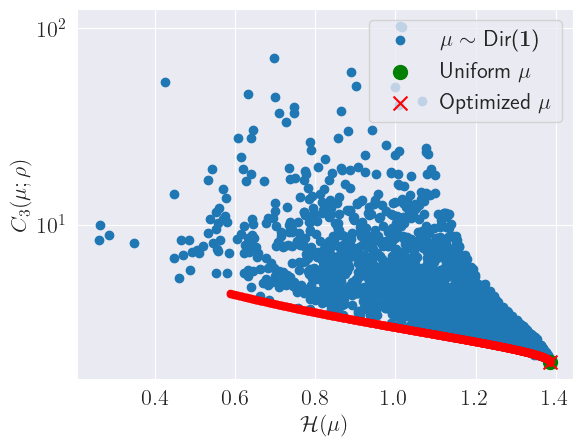

In [19]:
TRAJECTORY_PLOT_RESAMPLING = 10

sampled_mus_c_vals, sampled_mus_entropies = calculate_c_vals_from_sampled_mus(four_state_mdp,
                        rho=four_state_mdp_rho, M=four_state_mdp_M,
                        dirichlet_alpha=1.0,
                        num_samples=2_000, use_soft_max=four_state_mdp_use_soft_max)

nS = four_state_mdp["state_space_size"]
uniform_mu = np.ones(nS) / nS
uniform_mu_entropy = entropy(uniform_mu)
uniform_mu_c_val, _, _ = eval_mu(four_state_mdp, uniform_mu, rho=four_state_mdp_rho,
                                M=four_state_mdp_M, use_soft_max=four_state_mdp_use_soft_max)
print("Uniform mu C value", uniform_mu_c_val)
print("Uniform mu entropy", uniform_mu_entropy)

plt.scatter(sampled_mus_entropies, sampled_mus_c_vals, label=r"$\mu \sim$ Dir($\mathbf{1}$)")
plt.scatter(uniform_mu_entropy, uniform_mu_c_val, c='g', s=100, label=r"Uniform $\mu$")

# Plot trajectory.
print(len(c_vals))
print(len(mus))
c_vals_resampled = c_vals[::TRAJECTORY_PLOT_RESAMPLING]
mus_resampled = mus[::TRAJECTORY_PLOT_RESAMPLING]
mus_entropies = [entropy(x) for x in mus_resampled]
plt.plot(mus_entropies, c_vals_resampled, c='r')
plt.scatter(mus_entropies, c_vals_resampled, c='r', s=20)

plt.scatter(entropy(mus[lowest_c_val_idx]), lowest_c_val, c='r', marker='x', s=100, label=r"Optimized $\mu$", zorder=1000)

plt.yscale('log')
plt.xlabel(r'$\mathcal{H}(\mu)$')
plt.ylabel(r'$C_3(\mu;\rho)$')
plt.legend()
plt.show()
#plt.savefig('exampleMDP_comparison_plot.pdf', bbox_inches='tight', pad_inches=0)